# Unusual Trade Detection Using Unsupervised Machine Learning Models
*IEOR E4511 Project Report*

*Wenqu Wang, Shruti Agarwal, Jinyi Zhang*
#### Import Required Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.layers import Input, Dense
from keras.models import Model

## Data Pre-Processing
### Read Data
Trying small dataset on local computer.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Trovares/trovares.csv',nrows=5000000)

<ipython-input-3-ee742153257c>:1: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Trovares/trovares.csv',nrows=5000000)


In [4]:
pd.unique(df['SYM_ROOT'])

array(['A', 'AA', 'AAA', 'AAAU', 'AAC', 'AACG', 'AACI', 'AADI', 'AADR',
       'AAIC', 'AAIN', 'AAL', 'AAM', 'AAMC', 'AAME', 'AAN', 'AAOI',
       'AAON', 'AAP', 'AAPB', 'AAPD', 'AAPL'], dtype=object)

Dataset was too large, only read the first 50 million rows, which only covers the trading data of the first few `SYM_ROOT`(stock ticker).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   DATE         object 
 1   TIME_M       object 
 2   EX           object 
 3   SYM_ROOT     object 
 4   SYM_SUFFIX   object 
 5   TR_SCOND     object 
 6   SIZE         int64  
 7   PRICE        float64
 8   TR_STOP_IND  object 
 9   TR_CORR      int64  
 10  TR_SEQNUM    int64  
 11  TR_ID        int64  
 12  TR_SOURCE    object 
 13  TR_RF        object 
dtypes: float64(1), int64(4), object(9)
memory usage: 534.1+ MB


Foe simplicity, only select the `AAPL` rows, which contains all the milisecond level trade of `AAPL` from 2022-12-01 to 2022-12-30.

In [6]:
df_aapl = df[df['SYM_ROOT'] == 'AAPL']
df_aapl

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_STOP_IND,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
2167929,2022-12-01,4:00:00.008549370,K,AAPL,NaN,@ T,150,148.0800,NaN,0,1973,1,N,NaN
2167930,2022-12-01,4:00:00.015144352,K,AAPL,NaN,@ T,100,148.0800,NaN,0,1979,2,N,NaN
2167931,2022-12-01,4:00:00.015294500,K,AAPL,NaN,@ TI,20,148.0800,NaN,0,1980,3,N,NaN
2167932,2022-12-01,4:00:00.016654334,K,AAPL,NaN,@ TI,1,148.0800,NaN,0,1983,4,N,NaN
2167933,2022-12-01,4:00:00.016756830,K,AAPL,NaN,@ TI,50,148.0800,NaN,0,1984,5,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,2022-12-08,10:40:05.826893798,D,AAPL,NaN,@,300,143.0294,NaN,0,1491108,59578,N,Q
4999996,2022-12-08,10:40:05.999991465,D,AAPL,NaN,@ I,3,143.0250,NaN,0,1491194,59579,N,Q
4999997,2022-12-08,10:40:06.026974977,D,AAPL,NaN,@ I,1,143.0288,NaN,0,1491202,59580,N,Q
4999998,2022-12-08,10:40:06.415253611,Q,AAPL,NaN,@F,100,143.0200,NaN,0,1491272,28708,N,NaN


### Data Aggregation
The data points are in miliseconds, which makes the dataset so big. The first step would be aggregating data points into second-level.

In [7]:
df_aapl.TIME_M = pd.to_datetime(df_aapl.TIME_M)

<ipython-input-7-8076abf206e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl.TIME_M = pd.to_datetime(df_aapl.TIME_M)


In [8]:
df_aapl['HOUR'] = df_aapl['TIME_M'].dt.hour
# df_aapl['HOUR'] = df_aapl['TIME_M'].dt.month
df_aapl['TIME_S'] = df_aapl['TIME_M'].dt.strftime('%H:%M:%S')
df_aapl['TIME_M'] = df_aapl['TIME_M'].dt.strftime('%H:%M')

<ipython-input-8-e140bc23412b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl['HOUR'] = df_aapl['TIME_M'].dt.hour
<ipython-input-8-e140bc23412b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl['TIME_S'] = df_aapl['TIME_M'].dt.strftime('%H:%M:%S')
<ipython-input-8-e140bc23412b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [9]:
df_aapl = df_aapl.drop(columns=['TR_ID','TR_SEQNUM'])

In [10]:
df_sub = df_aapl[['DATE','TIME_S','HOUR','EX', 'SYM_ROOT','SYM_SUFFIX','TR_SCOND','TR_CORR','TR_SOURCE','PRICE','SIZE']]
df_second = df_sub.groupby(['DATE','TIME_S','HOUR','EX','SYM_ROOT','TR_SCOND','TR_CORR','TR_SOURCE'], as_index=False).agg(
    PRICE=('PRICE', np.mean),
    SIZE=('SIZE', np.sum))
df_second

,DATE,TIME_S,HOUR,EX,SYM_ROOT,TR_SCOND,TR_CORR,TR_SOURCE,PRICE,SIZE
0,2022-12-01,04:00:00,4,K,AAPL,@ T,0,N,148.080000,250
1,2022-12-01,04:00:00,4,K,AAPL,@ TI,0,N,147.951818,205
2,2022-12-01,04:00:00,4,K,AAPL,@FT,0,N,147.500000,100
3,2022-12-01,04:00:00,4,K,AAPL,@FTI,0,N,147.518000,144
4,2022-12-01,04:00:00,4,P,AAPL,@ T,0,N,147.426667,524
...,...,...,...,...,...,...,...,...,...,...
992765,2022-12-08,10:40:05,10,X,AAPL,@F,0,N,143.020000,215
992766,2022-12-08,10:40:05,10,Z,AAPL,@F,0,N,143.020000,100
992767,2022-12-08,10:40:06,10,D,AAPL,@ I,0,N,143.028800,1
992768,2022-12-08,10:40:06,10,Q,AAPL,@F,0,N,143.020000,100


In [11]:
df_sub2 = df_aapl[['DATE','TIME_M','HOUR','EX', 'SYM_ROOT','SYM_SUFFIX','TR_SCOND','TR_CORR','TR_SOURCE','PRICE','SIZE']]
df_minute = df_sub2.groupby(['DATE','TIME_M','HOUR','EX','SYM_ROOT','TR_SCOND','TR_CORR','TR_SOURCE'], as_index=False).agg(
    PRICE=('PRICE', np.mean),
    SIZE=('SIZE', np.sum))
# df_minute1 = df_minute.copy()
df_minute

,DATE,TIME_M,HOUR,EX,SYM_ROOT,TR_SCOND,TR_CORR,TR_SOURCE,PRICE,SIZE
0,2022-12-01,04:00,4,K,AAPL,@ T,0,N,148.080000,250
1,2022-12-01,04:00,4,K,AAPL,@ TI,0,N,147.855000,306
2,2022-12-01,04:00,4,K,AAPL,@FT,0,N,147.563333,1194
3,2022-12-01,04:00,4,K,AAPL,@FTI,0,N,147.643846,409
4,2022-12-01,04:00,4,P,AAPL,@ T,0,N,147.426667,524
...,...,...,...,...,...,...,...,...,...,...
113892,2022-12-08,10:40,10,V,AAPL,@,0,N,143.010000,200
113893,2022-12-08,10:40,10,X,AAPL,@F,0,N,143.020000,215
113894,2022-12-08,10:40,10,Z,AAPL,@ I,0,N,143.000000,4
113895,2022-12-08,10:40,10,Z,AAPL,@F,0,N,143.020000,100


In [12]:
print(df_aapl.shape[0],df_second.shape[0],df_minute.shape[0])

2832071 992770 113897


The size of dataset is reduced from 2832071 to 992770 and 113897.

### Feature Encoding
Use one-hot encoding for categorical features.

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df_minute[['EX','TR_SCOND','TR_CORR','TR_SOURCE']]).toarray())
train_df = df_minute.join(encoder_df).drop(columns=['DATE','TIME_M','EX','SYM_ROOT','TR_SCOND','TR_CORR','TR_SOURCE'])
train_df

,HOUR,PRICE,SIZE,0,1,2,3,4,5,6,...,57,58,59,60,61,62,63,64,65,66
0,4,148.080000,250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,4,147.855000,306,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,147.563333,1194,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,147.643846,409,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,147.426667,524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113892,10,143.010000,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
113893,10,143.020000,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
113894,10,143.000000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
113895,10,143.020000,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Models
### Isolation Forest


In [16]:
anomaly_inputs = ['PRICE','SIZE','HOUR','TR_CORR']

In [45]:
train_size = int(0.8 * len(train_df))
X_train, X_test = train_df[:train_size], train_df[train_size:]

In [46]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [47]:
model_IF = IsolationForest(contamination=0.001,random_state=42, max_samples = 'auto', n_estimators = 100)

In [48]:
model_IF.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, random_state=42)

In [49]:
X_test['anomaly'] = model_IF.predict(X_test)

<ipython-input-49-a9aaf9d9fae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['anomaly'] = model_IF.predict(X_test)


In [50]:
X_test[X_test['anomaly']!=1]

,HOUR,PRICE,SIZE,0,1,2,3,4,5,6,...,58,59,60,61,62,63,64,65,66,anomaly
91143,10,141.224075,158262,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91203,10,140.968980,145840,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91258,10,141.046711,130888,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91313,10,141.459641,147837,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91367,10,141.459674,125286,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111532,9,141.802181,140115,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
111667,9,142.016190,136607,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
111713,9,141.875684,112955,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
111761,9,142.086331,137434,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1


### One-class SVM

In [51]:
train_size = int(0.8 * len(train_df))
X_train, X_test = train_df[:train_size], train_df[train_size:]
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [52]:
model_svm = OneClassSVM(kernel='rbf', gamma = 'auto', nu=0.001)  # Set the kernel and nu parameter
model_svm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.001)

In [53]:
X_test['anomaly'] = model_svm.predict(X_test)
X_test[X_test['anomaly']!=1]

<ipython-input-53-4c4266ec1a0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['anomaly'] = model_svm.predict(X_test)


,HOUR,PRICE,SIZE,0,1,2,3,4,5,6,...,58,59,60,61,62,63,64,65,66,anomaly
91121,10,141.622083,2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91127,10,141.629815,6100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91131,10,141.165833,28449,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91133,10,141.150513,30547,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
91134,10,141.077609,1210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113840,10,143.033636,1733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
113849,10,143.049304,13096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
113851,10,143.064946,16673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
113869,10,143.062554,11484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1


In [55]:
X_test.shape

(22780, 71)

###Autoencoder

In [94]:
X_train = train_df.sample(frac=0.8, random_state=42)
X_test = train_df.drop(X_train.index)

In [95]:
# Define the autoencoder model
input_shape = X_train.shape[1]
encoder = keras.Sequential([
  layers.Dense(64, activation='relu', input_shape=(input_shape,)),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(4, activation='relu')
])
decoder = keras.Sequential([
  layers.Dense(8, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(input_shape, activation='linear')
])
autoencoder = keras.Sequential([encoder, decoder])
# autoencoder.add(layers.Dropout(0.3))
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [96]:
autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 4)                 7324      
                                                                 
 sequential_7 (Sequential)   (None, 70)                7390      
                                                                 
Total params: 14,714
Trainable params: 14,714
Non-trainable params: 0
_________________________________________________________________


In [101]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min') # if the monitored metric does not change wrt to the mode applied for 3 epochs, stop training
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_split = 0.2, callbacks=[early_stop])

Epoch 1/100
2278/2278 [==============================] - 9s 4ms/step - loss: 2961837.0000 - val_loss: 788760.3125
Epoch 2/100
2278/2278 [==============================] - 7s 3ms/step - loss: 74449312.0000 - val_loss: 3691562.5000
Epoch 3/100
2278/2278 [==============================] - 8s 3ms/step - loss: 3045872.2500 - val_loss: 3896515.5000
Epoch 4/100
2278/2278 [==============================] - 7s 3ms/step - loss: 4935353.5000 - val_loss: 102323.8750
Epoch 5/100
2278/2278 [==============================] - 7s 3ms/step - loss: 16373627.0000 - val_loss: 9364754.0000
Epoch 6/100
2278/2278 [==============================] - 7s 3ms/step - loss: 2674692.5000 - val_loss: 820375.6250
Epoch 7/100
2278/2278 [==============================] - 7s 3ms/step - loss: 2115123.5000 - val_loss: 1715598.2500


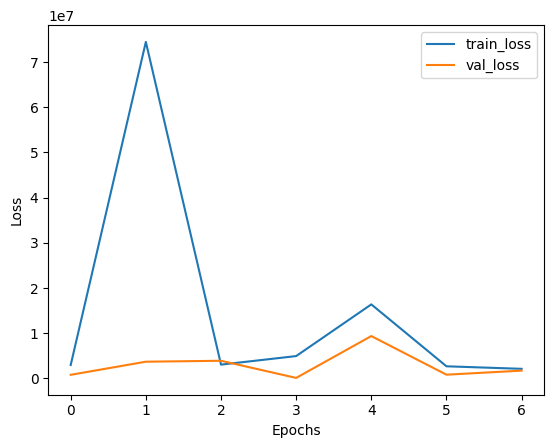

In [102]:
plt.figure()
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [103]:
# Calculate mae for test data
y_pred_auto = autoencoder.predict(X_test)
test_mae_loss = np.mean(np.abs(y_pred_auto - X_test),axis=1)

712/712 [==============================] - 1s 2ms/step


In [104]:
X_test.shape

(22779, 70)

In [105]:
y_pred_auto = pd.DataFrame(y_pred_auto)
y_pred_auto

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,10.436945,34.414146,1318.048706,-9.040943,5.940639,9.021455,13.049602,12.488110,12.219987,46.320671,...,-24.719896,11.787982,37.547039,19.662958,40.639923,12.925433,-54.562363,8.612078,-29.274784,39.821625
1,7.924597,47.814579,392.028809,-9.412323,0.320522,2.649264,2.926406,3.377835,-2.378951,15.031335,...,-7.939111,3.111225,11.653686,1.347854,22.567383,6.296739,-24.796005,-3.852648,-11.794346,12.852169
2,7.258896,60.118851,177.336212,-10.559225,-2.042965,0.976474,1.565591,1.863987,-6.315838,11.149745,...,-5.885532,-0.596897,7.416378,-2.807810,20.037598,2.961676,-19.520540,-6.915370,-9.710962,9.231465
3,8.598711,42.102058,726.138000,-9.047533,2.487147,4.633405,6.531196,6.817246,3.058789,25.909975,...,-13.730945,6.161752,21.140686,8.228064,28.681520,8.764564,-35.228458,0.965849,-17.630569,22.435551
4,7.892493,48.370972,363.681030,-9.435471,0.143463,2.575068,2.597184,3.058337,-2.868056,14.157517,...,-7.497858,2.886587,10.797751,0.706026,22.091312,6.067037,-23.903992,-4.282944,-11.380005,12.020120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22774,6.431808,68.481430,198.879715,-11.786314,-2.241530,0.590424,1.601018,2.447407,-7.416820,13.994349,...,-7.242218,-0.922903,9.246839,-2.333399,23.630424,2.316589,-23.312811,-6.301517,-10.975557,12.257766
22775,6.489290,68.254463,199.566727,-11.798111,-2.249056,0.603278,1.635190,2.431409,-7.366796,13.965665,...,-7.213607,-0.905498,9.219081,-2.310808,23.567713,2.304729,-23.267563,-6.302427,-10.994982,12.218500
22776,7.797048,52.314579,227.169296,-8.851612,-0.863444,2.137328,1.709071,1.972109,-5.097801,10.289200,...,-5.491100,1.363551,7.162847,-2.290569,19.483658,4.770678,-19.186007,-6.212095,-9.424730,7.952308
22777,7.800522,52.314281,227.673813,-8.850500,-0.863826,2.140013,1.719331,1.978490,-5.088041,10.309790,...,-5.501724,1.365169,7.179786,-2.280025,19.493198,4.774269,-19.203585,-6.207330,-9.435863,7.969837


In [106]:
# Use the trained model to detect anomalies
# mse = np.mean(np.power(X_test - y_pred_auto, 2), axis=1)
# mse_threshold = np.quantile(mse, 0.999)  # Set the threshold to detect 0.1% of the data as anomalous

mse = np.mean(np.power(X_test - autoencoder.predict(X_test), 2), axis=1)
mse_threshold = np.quantile(mse, 0.999)  # Set the threshold to detect 0.1% of the data as anomalous



712/712 [==============================] - 1s 2ms/step


In [107]:
# Compute the reconstruction errors
X_test['anomaly'] = np.where(mse > mse_threshold, -1, 1)

In [117]:
X_test.sort_values(by = 'anomaly')

,HOUR,PRICE,SIZE,0,1,2,3,4,5,6,...,58,59,60,61,62,63,64,65,66,anomaly
48743,10,147.982524,181720,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
46686,10,148.898230,171475,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
3009,9,148.340000,720606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
45371,9,150.144805,175231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
5380,10,146.893229,176301,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37436,14,146.220000,100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
37430,14,146.224000,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
37425,14,146.299545,761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
37322,14,146.321429,1179,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


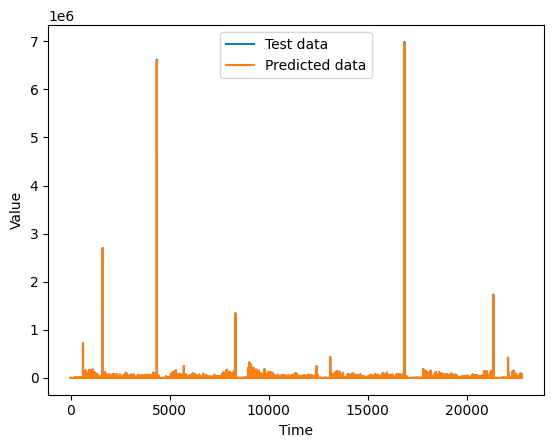

In [93]:
# Assuming test_data and predicted_data are NumPy arrays
x = np.arange(len(X_test))

plt.plot(x, X_test.iloc[:,2], label='Test data')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
plt.plot(x, y_pred_auto.iloc[:,2], label='Predicted data')

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()